# SINE WAVE MODEL
This script is to develop a model to predict the sine of a value. The model is deployed to a stm32 board (nucleo-l476rg). The model is converted to a tflite model to be run with the tensorflowlite-micro tflm frame work.

## Importing the needed library

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Defining necessary libraries

In [12]:
SAMPLE_SIZE = 1_000
RANDOM_SEED = 25
PI = 3.14159265359

MODEL_FILE_NAME = "SINE_MODEL"
C_HEADER_DIR = "../deployment/include/"

train_ratio = .7
test_ratio = .2
validation_ratio = .1

## Generating the dataset
The data will contain numbers between 0 and 2pi, the sine function will be defined in rad.
A random uniform error is added to the sine values to give the dataset a bit of variability and see how the model will perform.
The error is centred with a mean of 0 and std 0f 0.05. This is chosen such that 95% of the error is -0.2 and 0.+2.

In [37]:
np.random.seed(RANDOM_SEED) # for reproduction
tf.random.set_seed(RANDOM_SEED)
 
x = np.random.uniform(low=0, high=2*PI, size=SAMPLE_SIZE)
y = np.sin(x) + np.random.normal(0, 0.1, size=SAMPLE_SIZE)
x.shape, y.shape

((1000,), (1000,))

### Plot of the data
1. The distribution of the imput data.
2. The relationship between the output y and x i.e. the sine curve.

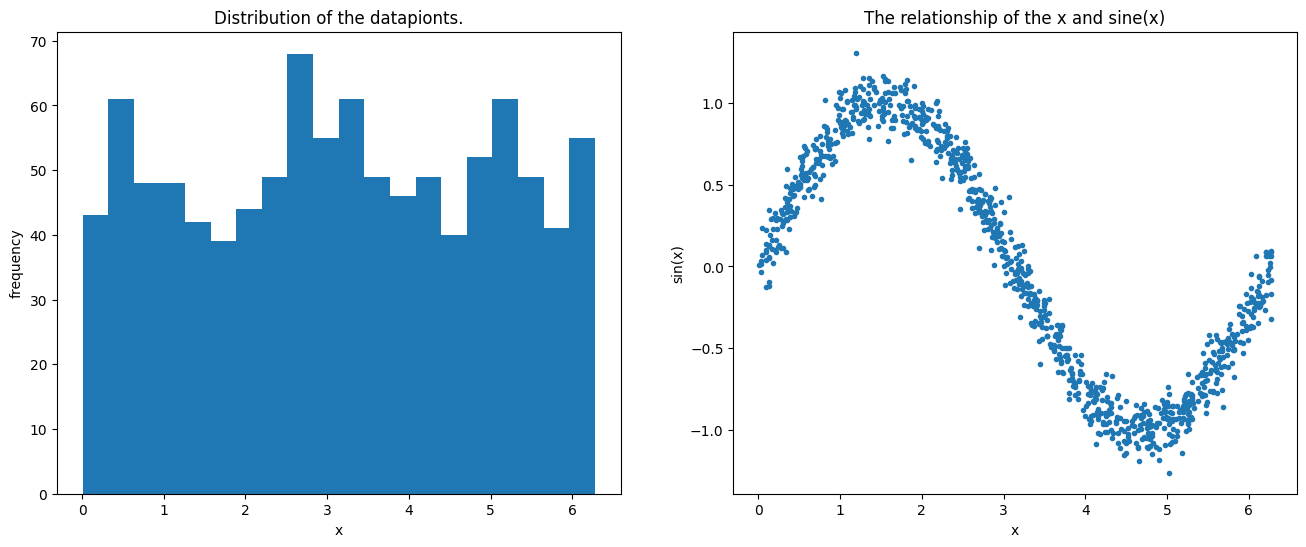

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

axes[0].hist(x, bins=20)
axes[0].set_title("Distribution of the datapionts.")
axes[0].set_xlabel("x")
axes[0].set_ylabel("frequency")


axes[1].scatter(x,y, marker=".")
axes[1].set_title("The relationship of the x and sine(x)")
axes[1].set_ylabel("sin(x)")
axes[1].set_xlabel("x")

plt.show()

## Preparing the data for training

In [39]:
# x_train = x[:SAMPLE_SIZE * train_ratio]
# y_train = y[:SAMPLE_SIZE * train_ratio]

# x_test = x[SAMPLE_SIZE * train_ratio : SAMPLE_SIZE * test_ratio]
# y_test = y[SAMPLE_SIZE * train_ratio : SAMPLE_SIZE * test_ratio]

# x_validate = x[SAMPLE_SIZE * (1 - validation_ratio):]
# y_validate = y[SAMPLE_SIZE * (1 - validation_ratio):]

x_train, x_test, x_validate = np.split(x, [int(train_ratio*SAMPLE_SIZE), int((train_ratio+test_ratio)*SAMPLE_SIZE)])
y_train, y_test, y_validate = np.split(y, [int(train_ratio*SAMPLE_SIZE), int((train_ratio+test_ratio)*SAMPLE_SIZE)])

### Make a plot to show to distribution of the training, testing and validation data.

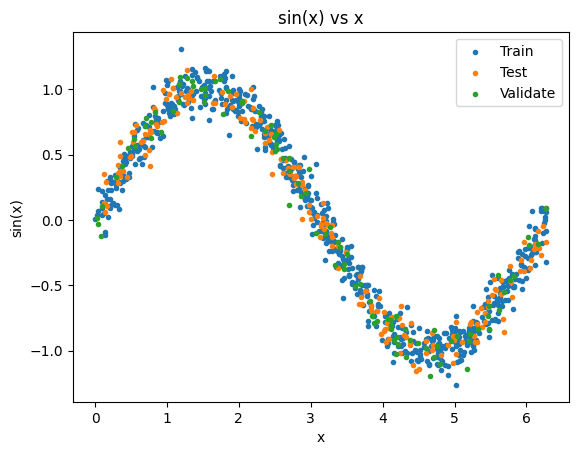

In [40]:
plt.scatter(x_train, y_train,marker=".", label="Train")
plt.scatter(x_test, y_test, marker=".", label="Test")
plt.scatter(x_validate, y_validate, marker=".", label="Validate")

plt.title("sin(x) vs x")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.legend()
plt.show()

## Model Definition
A simple  model will be used to test the framework. A 2 [hidden] layer model with the following:
- Input layer -> 1 neuron
- Hidden layer 1 -> 32 neurons
- Hidden layer 2 -> 16 neurons
- Output layer -> 1 neuron

In [41]:
sine_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu", input_shape=(1,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])

/home/matthias/Documents/EmbeddedAI/stm32-tinyml-sine/development/tf_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
sine_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609 (2.38 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
sine_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = sine_model.fit(x_train, y_train, batch_size=100, epochs=1000, validation_data=(x_validate, y_validate))

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.7403 - mae: 0.7552 - val_loss: 0.5857 - val_mae: 0.6928
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4855 - mae: 0.6201 - val_loss: 0.4776 - val_mae: 0.6077
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4122 - mae: 0.5496 - val_loss: 0.4529 - val_mae: 0.5768
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3960 - mae: 0.5335 - val_loss: 0.4327 - val_mae: 0.5678
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3738 - mae: 0.5219 - val_loss: 0.4158 - val_mae: 0.5643
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3551 - mae: 0.5122 - val_loss: 0.3985 - val_mae: 0.5549
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3379 - mae: 0.4995 - val_loss: 0.3773 - val_mae: 0.5383
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3203 - mae: 0.4851 - val_loss: 0.3576 - val_mae: 0.5246
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3036 

## Training Plot

Text(0, 0.5, 'mae')

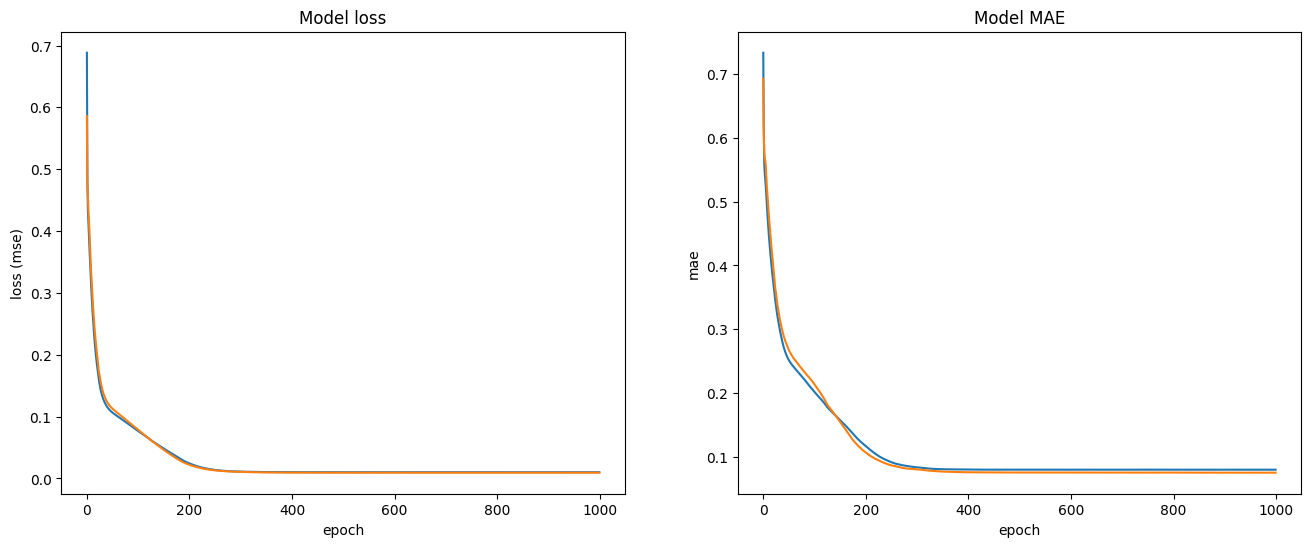

In [44]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6))

axes[0].plot(history.history["loss"], label="training_loss")
axes[0].plot(history.history["val_loss"], label="validation_loss")
axes[0].set_title("Model loss")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss (mse)")

axes[1].plot(history.history["mae"], label="training_mae")
axes[1].plot(history.history["val_mae"], label="validation_loss")
axes[1].set_title("Model MAE")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("mae")

## Testing the model

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


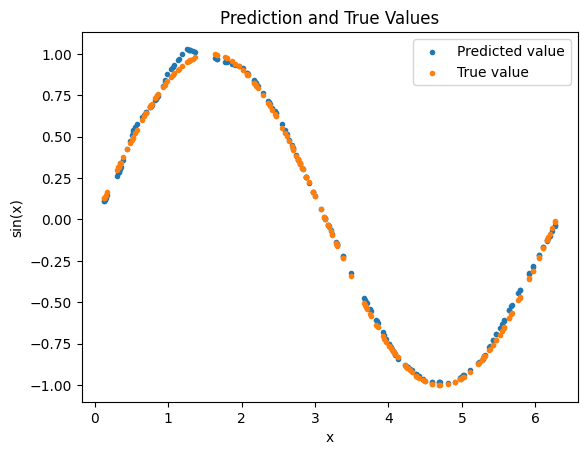

In [45]:
y_test_predict = sine_model.predict(x_test)
y_test_true = np.sin(x_test)

plt.scatter(x_test, y_test_predict, marker=".", label="Predicted value")
plt.scatter(x_test, y_test_true, marker=".", label="True value")
plt.title("Prediction and True Values")
plt.ylabel("sin(x)")
plt.xlabel("x")
plt.legend()

## Converting the model to tflite

In [46]:
converter = tf.lite.TFLiteConverter.from_keras_model(sine_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
sine_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpxfsi6fma/assets


INFO:tensorflow:Assets written to: /tmp/tmpxfsi6fma/assets


Saved artifact at '/tmp/tmpxfsi6fma'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='keras_tensor_12')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  128866896448016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128866901225936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128866901226896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128866901227856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128866901224016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128866901226128: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1747036514.151741   23422 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747036514.151753   23422 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-12 08:55:14.151906: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxfsi6fma
2025-05-12 08:55:14.152298: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-12 08:55:14.152306: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpxfsi6fma
2025-05-12 08:55:14.155234: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-12 08:55:14.175406: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpxfsi6fma
2025-05-12 08:55:14.182715: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 30811 microseconds.


## Converting the model to the c format

In [47]:
# Breaking the byte in several lines to fit better in the c header file
sine_tflite_model_split_line = np.array_split([format(hex_value, '#04x') for hex_value in sine_tflite_model], len(sine_tflite_model)//8)

# Write TfLite model to a C header file
open(f"{C_HEADER_DIR}{MODEL_FILE_NAME}.h", "w").write(
f"""
#ifndef {MODEL_FILE_NAME.upper()}_H
#define {MODEL_FILE_NAME.upper()}_H

const unsigned int {MODEL_FILE_NAME.lower()}_len = {len(sine_tflite_model)};

const unsigned char {MODEL_FILE_NAME.lower()}[{len(sine_tflite_model)}] = {{
    {",\n    ".join([", ".join(line) for line in sine_tflite_model_split_line])}
}};

#endif // {MODEL_FILE_NAME.upper()}_H
"""
)

# Saving the TfLite model
open(f"{MODEL_FILE_NAME}.tflite", "wb").write(sine_tflite_model)

4388

## Testing the converted tflite model

In [48]:
interpreter = tf.lite.Interpreter(model_path=f"{MODEL_FILE_NAME}.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

y_test_tflite_predict = []
for x_ in x_test:
  # Set input tensor
  interpreter.set_tensor(input_details[0]['index'], np.array([[x_]], dtype=np.float32))

  # Run the inference
  interpreter.invoke()

  y_test_tflite_predict.append(interpreter.get_tensor(output_details[0]['index']))

y_test_tflite_predict = np.array(y_test_tflite_predict)


/home/matthias/Documents/EmbeddedAI/stm32-tinyml-sine/development/tf_env/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Text(0.5, 0, 'model type')

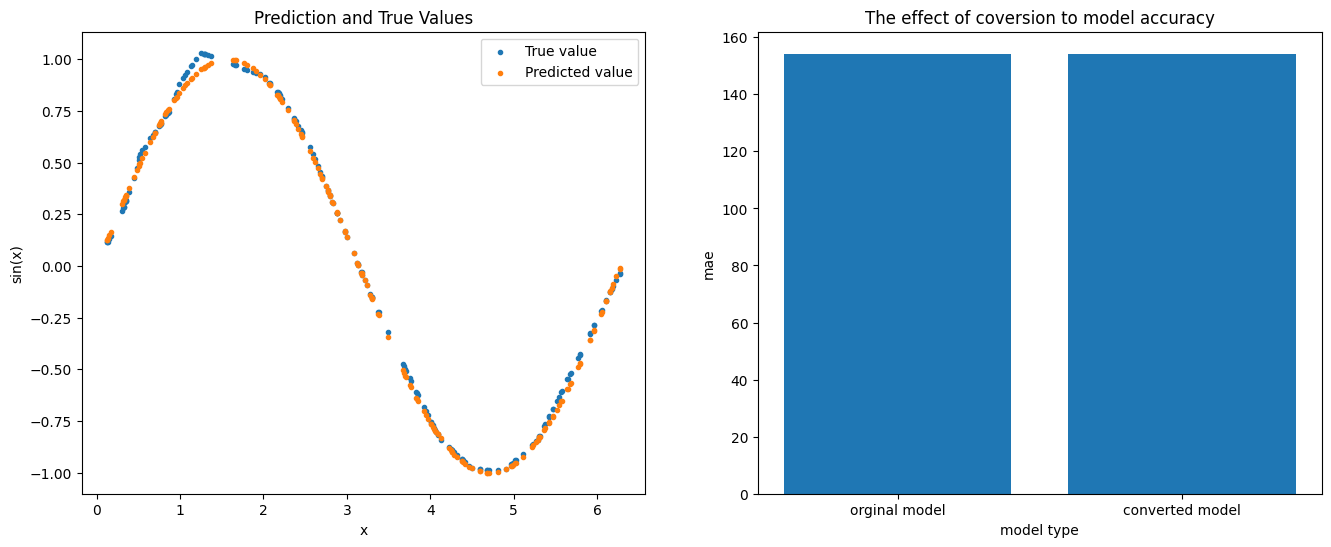

In [49]:
y_test_predict = sine_model.predict(x_test)
y_test_true = np.sin(x_test)

mae_orginal_model = np.sum(np.abs(y_test_predict - y_test)) / y_test.shape[0]
mae_converted_model = np.sum(np.abs(y_test_tflite_predict - y_test)) / y_test.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16,6))

axes[0].scatter(x_test, y_test_tflite_predict, marker=".", label="True value")
axes[0].scatter(x_test, y_test_true, marker=".", label="Predicted value")
axes[0].set_title("Prediction and True Values")
axes[0].set_ylabel("sin(x)")
axes[0].set_xlabel("x")
axes[0].legend()

axes[1].bar(["orginal model", "converted model"], [mae_orginal_model, mae_converted_model])
axes[1].set_title("The effect of coversion to model accuracy")
axes[1].set_ylabel("mae")
axes[1].set_xlabel("model type")
